# Multi-Task Transformer

In this notebook, a multi-task transformer based on the pre-trained [BERT](https://huggingface.co/google-bert/bert-base-german-cased) model is constructed, where each task corresponds to one annotator. For each data point, the CLS token is extracted and scored using a tf-idf dictionary created from the dataframe.

Following the model creation, fine-tuning is performed on the augmented dataset. During fine-tuning, various hyperparameter configurations and feature selections are experimented with.

The training process is conducted in two stages: initially, a binary classification determines whether a data point exhibits sexism, followed by a more detailed classification of the level of sexism for each predicted instance.

In [1]:
!pip install transformers -q
!pip install torch -q
!pip install textblob -q
!pip install spacy -q
!pip install transformers[torch] -q
!pip install accelerate -U -q
!python -m spacy download de_core_news_sm -q
!pip install germansentiment -q
!pip install matplotlib -q

✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import spacy
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.optim import SGD, Adam, AdamW
from transformers import BertTokenizer, BertModel, BertConfig, AutoModel, pipeline, get_linear_schedule_with_warmup
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForTokenClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from torch.utils.data import DataLoader, Dataset
from textblob import TextBlob
from spacy.lang.de.examples import sentences
from tqdm import tqdm
from germansentiment import SentimentModel
from sklearn.utils.class_weight import compute_class_weight

### Model Building

Various pre-trained models were evaluated, all specifically trained on the German language or multilingual datasets. Eventually, fine-tuning and feature engineering with bert-base-german-cased yielded the best performance.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nlp = spacy.load("de_core_news_sm")
ANNOTATOR_COLUMNS = ['A001', 'A002', 'A003', 'A004', 'A005', 'A007', 'A008', 'A009', 'A010', 'A012']

checkpoint = "google-bert/bert-base-german-cased"

# "google-bert/bert-base-german-cased"
# "google-bert/bert-base-multilingual-cased"
# "FacebookAI/xlm-roberta-large-finetuned-conll03-german"
# "ml6team/distilbert-base-german-cased-toxic-comments"

In [7]:
class MultiTaskModel(nn.Module):
    """
    Multi-task Transformer model using BERT-based embeddings for annotation tasks.
    Each tasks corresponds to the prediction of one annotator.

    Args:
        tfidf_dicts (dict): Dictionary containing TF-IDF scores for each document.
        nr_preds (int): Number of predictions per annotator (either 2 for binary, 4 for multi-class).
        num_annotators (int): Number of annotators.
        bert_model (str): Pre-trained BERT model checkpoint.
        bert_dim (int): Dimension of BERT embeddings. Typically 768, however larger when incorporating additional features.
        tfidf (bool): Flag indicating whether to use TF-IDF features.
        sent (bool): Flag indicating whether to include sentiment feature
    """

    def __init__(self, tfidf_dicts=None, nr_preds=2, num_annotators=10, bert_model=checkpoint, bert_dim=768, tfidf=False, sent=False):
        
        super(MultiTaskModel, self).__init__()
        self.num_annotators = num_annotators
        self.tfidf_dicts = tfidf_dicts
        self.nr_preds = nr_preds
        self.tfidf = tfidf
        self.sent = sent
        
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        self.bert = AutoModel.from_pretrained(checkpoint)
        self.sentiment_model = SentimentModel()
        
        self.bert_dim = bert_dim
        if sent:
            self.bert_dim = bert_dim + 3

        # Shared layers
        self.shared_dense1 = nn.Linear(self.bert_dim, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.batch_norm1 = nn.BatchNorm1d(128)

        self.shared_dense2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.batch_norm2 = nn.BatchNorm1d(64)

        # Annotator-specific output layers
        self.annotator_heads = nn.ModuleDict({
            str(name): nn.Linear(64, nr_preds) for name in ANNOTATOR_COLUMNS
        })

    def forward(self, input_ids, doc_idx, attention_mask=None, token_type_ids=None):
        """
        Performs forward pass through the model.
        """
        outputs = self.bert(input_ids, attention_mask=attention_mask, return_dict=True) #token_type_ids=token_type_ids,

        # Extract the CLS token output for classification
        cls_token = outputs.last_hidden_state[:, 0, :] # shape 8x768

        # Apply TF-IDF features if enabled
        if self.tfidf:
            tfidf_scores = self.compute_tfidf(input_ids, doc_idx)
            cls_token = cls_token * tfidf_scores[:, 0].unsqueeze(-1)

        # Apply sentiment analysis features if enabled
        if self.sent:
            additional_features = self.compute_additional_features(input_ids)
            # Concatenate CLS token with additional features
            cls_token = torch.cat((cls_token, additional_features), dim=1)

        # Shared layers
        shared_layer = self.shared_dense1(cls_token) # weigths shape 512x128
        shared_layer = torch.relu(shared_layer)
        shared_layer = self.dropout1(shared_layer)
        shared_layer = self.batch_norm1(shared_layer)

        shared_layer = self.shared_dense2(shared_layer)
        shared_layer = torch.relu(shared_layer)
        shared_layer = self.dropout2(shared_layer)
        shared_layer = self.batch_norm2(shared_layer)

        # Annotator-specific heads for binary and multi-label classification
        if self.nr_preds==2:
            outputs = {str(column_name): torch.sigmoid(head(shared_layer)) for column_name, head in self.annotator_heads.items()}
        elif self.nr_preds==4:
            outputs = {str(column_name): torch.softmax(head(shared_layer), dim=-1) for column_name, head in self.annotator_heads.items()}

        return outputs

    def compute_tfidf(self, input_ids, doc_idx):
        """
        Computes TF-IDF scores for input tokens.
        """
        batch_size = input_ids.size(0)
        tfidf_scores_batch = []

        for i in range(batch_size):
            tfidf_dict = self.tfidf_dicts[doc_idx[i].item()]
            tfidf_scores = torch.tensor(
              [tfidf_dict.get(self.tokenizer.decode([input_id]), 1.0) for input_id in input_ids[i]]
            ).float()
            tfidf_scores = tfidf_scores.to(input_ids.device) 
            tfidf_scores_batch.append(tfidf_scores)

        tfidf_scores_batch = torch.stack(tfidf_scores_batch)
        return tfidf_scores_batch

    def compute_additional_features(self, input_ids):
        """
        Computes additional features for input tokens. It was experimented with sentiment, length
        of entry, question and exclamation mark ratio.
        """
            
        additional_features = []

        for input_id in input_ids:
            text = self.tokenizer.decode(input_id, skip_special_tokens=True)
            #text_length = len(text.split())
            #question_mark_ratio = text.count('?') / text_length if text_length > 0 else 0
            #exclamation_mark_ratio = text.count('!') / text_length if text_length > 0 else 0

            classes, probabilities = self.sentiment_model.predict_sentiment([text], output_probabilities = True)
            sentiment_positive = probabilities[0][0][1]
            sentiment_negative = probabilities[0][1][1]
            sentiment_neutral = probabilities[0][2][1]
            additional_features.append([sentiment_positive, sentiment_negative, sentiment_neutral])

        return torch.tensor(additional_features).to(input_ids.device)

More detailed explanation about the incorporation of tf-idf scores can be found in the paper.

### Data Preparation

For fine-tuning we experimented a lot with the combination of additional features as well as pre-processing, such as upsampling minority classes or applying lemmatization to the dataframe. Both techniques yielded worse performance, thus were not utilized.

In [8]:
def upsample_minority_classes(df):
    """
    Upsamples minority classes in a DataFrame for each annotator column. Only for binary df.
    """
    upsampled_dfs = []

    for annotator in ANNOTATOR_COLUMNS:
        majority_class = df[df[annotator] == 0]
        minority_class = df[df[annotator] == 1]
        
        minority_upsampled = resample(
            minority_class, 
            replace=True,  
            n_samples=majority_class.shape[0], 
            random_state=42 
        )
        
        upsampled_df = pd.concat([majority_class, minority_upsampled])
        upsampled_dfs.append(upsampled_df)
    
    combined_upsampled_df = pd.concat(upsampled_dfs).drop_duplicates().reset_index(drop=True)  
    return combined_upsampled_df

def lemma(text):
    """ 
    Apply lemmatization and stopword removal. 
    """
    doc = nlp(text)
    result = ' '.join([
        token.text if token.is_punct else token.lemma_
        for token in doc
        if not token.is_stop
    ])
    return result.lower()

In [9]:
def get_train_df(split, path, upsample=False, lemmat=False):
    """
    Prepares training dataframes for binary and multi-class classification tasks with optional 
    data preprocessing, specifically upsampling and lemmatization. Method offers possibility
    to get only the original df, the df augmented once or augmented twice.
    """
    df = pd.read_csv(path)
    #df = df.drop('A011', axis=1)
    df = df.drop('Unnamed: 0', axis=1)

    if split == 1:
        end_index = 4486
    elif split == 2:
        end_index = 8972
    elif split==3:
        end_index = len(df)
    
    df = df[:end_index]

    # Binary classification
    df_bin = df.copy()
    df_bin[ANNOTATOR_COLUMNS] = df_bin[ANNOTATOR_COLUMNS].replace([2, 3, 4], 1)

    # Multi-class classification
    replace_dict = {0: -1, 1: 0, 2: 1, 3: 2, 4: 3}
    df_mul = df.copy()
    df_mul[ANNOTATOR_COLUMNS] = df_mul[ANNOTATOR_COLUMNS].replace(replace_dict)

    if upsample:
        df_bin = upsample_minority_classes(df_bin)
        df_mul = upsample_minority_classes(df_mul)
    if lemmat:
        df_bin['text'] = df_bin['text'].apply(lambda x: lemma(x))
        df_mul['text'] = df_mul['text'].apply(lambda x: lemma(x))
    
    return df, df_bin, df_mul

In [17]:
class MultiTaskDataset(Dataset):
    """
    Creates a PyTorch Dataset for multi-task learning with BERT-based models.

    Args:
        dataframe (DataFrame): Pandas DataFrame containing text data and annotations.
        max_len (int): Maximum length of tokenized inputs for padding/truncation.
    """
    def __init__(self, dataframe, max_len):
        self.dataframe = dataframe
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, item):
        text = self.dataframe.iloc[item]['text']
        labels = {annotator: torch.tensor(int(self.dataframe.iloc[item][annotator]), dtype=torch.int)
                  for annotator in ANNOTATOR_COLUMNS}

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels,
            'doc_idx': torch.tensor(item, dtype=torch.long)
        }

In [18]:
def get_tfidf_dict(df):
    """
    Utilizes TfidfVectorizer to compute TF-IDF scores for words in the text data stored in a DataFrame.
    Returns a list of dictionaries, where each dictionary maps words to their corresponding TF-IDF scores 
    for each document in the DataFrame. 
    """
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['text'])
    tfidf_scores = X.toarray()
    feature_names = vectorizer.get_feature_names_out()

    tfidf_dicts = [] 
    for doc_idx, doc in enumerate(df['text']):
        tfidf_dict = {word: tfidf_scores[doc_idx, idx] for idx, word in enumerate(feature_names) if tfidf_scores[doc_idx, idx] > 0}
        tfidf_dicts.append(tfidf_dict)
    return tfidf_dicts

def compute_class_weights(df, annotator_column):
    """ 
    To address the highly imbalanced dataframes, class weights for every annotator are calculated.
    """
    y = df[annotator_column].values
    y_filtered = y[y != -1]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_filtered), y=y_filtered)
    return torch.tensor(class_weights, dtype=torch.float)

### Define Data & Training Parameter

In [42]:
path='df_train_original.csv'
# order: df normal, df binary, df multi-class
_, _, df = get_train_df(split=3, path=path, upsample=False, lemmat=False)
df.head(2)

,text,A012,A003,A005,A001,A008,A004,A007,A010,A002,A009
0,"Wen man nicht reinläßt, den muss man auch nich...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,Und eine Katze die schnurrt genügt Ihnen? \nUn...,0,0,-1,-1,0,-1,0,-1,-1,-1


In [43]:
def get_criterion_dict():
    """ 
    Creates a dictionary of loss functions (criterions) for each annotator with class weights to handle imbalanced data.
    """
    class_weights_dict = {}
    criterion_dict = {}

    for annotator in ANNOTATOR_COLUMNS:
        class_weights = compute_class_weights(df, annotator)
        class_weights_dict[annotator] = class_weights.to(device)
        criterion_dict[annotator] = nn.CrossEntropyLoss(weight=class_weights.to(device))
    return criterion_dict

criterion_dict = get_criterion_dict()

In [44]:
max_len = 64 # as median and avg are 32
batch_size = 16
num_epochs = 8 # 7 for binary prediction, 8 epochs for multi-class 
learning_rate = 0.01 # 0.005 for binary prediction, 0.01 for multi-class 
weight_decay = 1e-4

In [52]:
tfidf_dicts = get_tfidf_dict(df)
model = MultiTaskModel(nr_preds=4, tfidf_dicts=tfidf_dicts, tfidf=True, sent=False)

In [46]:
annotator_mapping = {str(i): annotator for i, annotator in enumerate(df.columns[1:], start=0)}
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay, nesterov=True)

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#scheduler = get_linear_schedule_with_warmup(optimizer=sgd, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

In [47]:
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, val_df = train_test_split(shuffled_df, test_size=0.15, random_state=42)

train_dataset = MultiTaskDataset(train_df, max_len)
val_dataset = MultiTaskDataset(val_df, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataset = MultiTaskDataset(df, max_len)
#train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [48]:
total_steps = len(train_loader) * num_epochs
warmup_steps = 0.1 * total_steps

In [49]:
# evaluation while training after each epoch to control num epochs

def evaluate(model, loader):
    """
    Evaluates the model on the provided data loader. Will be called after each fine-tune epoch to supervise training.
    """
    model.eval() 
    
    test_loss = 0
    test_accuracy = 0
    test_batches = 0
    test_precision = 0
    test_recall = 0
    test_f1 = 0

    with torch.no_grad(): 
        for batch_idx, batch in enumerate(tqdm(loader, desc=f'Evaluating...')):
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            doc_idx = batch['doc_idx'].to(device)
            #model.to(device)

            outputs = model(input_ids, doc_idx, attention_mask)
            loss = 0

            for annotator, logits in outputs.items():
                annotator_labels = labels[annotator].long().to(device)
                mask = annotator_labels != -1  
                if mask.sum() > 0: 
                    masked_logits = logits[mask]
                    masked_labels = annotator_labels[mask]

                    criterion = criterion_dict[annotator]
                    loss += criterion(masked_logits, masked_labels)

                    predicted_labels = torch.argmax(masked_logits, dim=1).cpu().numpy()
                    true_labels = masked_labels.cpu().numpy()

                    accuracy = accuracy_score(true_labels, predicted_labels)
                    precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=1)
                    recall = recall_score(true_labels, predicted_labels, average='macro', zero_division=1)
                    f1 = f1_score(true_labels, predicted_labels, average='macro', zero_division=1)

                    test_accuracy += accuracy
                    test_precision += precision
                    test_recall += recall
                    test_f1 += f1

                    test_batches += 1

            test_loss += loss.item()

    avg_loss = test_loss / len(loader)
    avg_accuracy = test_accuracy / test_batches
    avg_precision = test_precision / test_batches
    avg_recall = test_recall / test_batches
    avg_f1 = test_f1 / test_batches

    print(f'Loss: {avg_loss:.3f}, Accuracy: {avg_accuracy:.3f}, Precision: {avg_precision:.3f}, Recall: {avg_recall:.3f}, F1 Score: {avg_f1:.3f}')

### Training

In [50]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs):
    """
    This function trains the given model using the training data loader for a specified number of epochs.
    """
    
    for epoch in range(num_epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))
        print('Training...')

        total_loss = 0
        total_accuracy = 0
        total_batches = 0
        total_precision = 0
        total_recall = 0
        total_f1 = 0

        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            doc_idx = batch['doc_idx'].to(device)

            model.to(device)
            model.train()

            optimizer.zero_grad() # clear any previously calculated gradients
            outputs = model(input_ids, doc_idx, attention_mask)

            loss = 0
            for annotator, logits in outputs.items():
                annotator_labels = labels[annotator].long()
                mask = annotator_labels != -1  # -1 indicates not present labels
                if mask.sum() > 0:
                    masked_logits = logits[mask]
                    masked_labels = annotator_labels[mask].to(logits.device)

                    criterion = criterion_dict[annotator]
                    loss += criterion(masked_logits, masked_labels)

                    predicted_labels = torch.argmax(masked_logits, dim=1)
                    accuracy = accuracy_score(masked_labels.cpu().numpy(), predicted_labels.cpu().numpy())
                    precision = precision_score(masked_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro', zero_division=1)
                    recall = recall_score(masked_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro', zero_division=1)
                    f1 = f1_score(masked_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro', zero_division=1)

                    total_accuracy += accuracy
                    total_precision += precision
                    total_recall += recall
                    total_f1 += f1

                    total_batches += 1

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
            optimizer.step()
            #scheduler.step()
            total_loss += loss.item()

        avg_accuracy = total_accuracy / total_batches
        avg_loss = total_loss / len(train_loader)
        avg_precision = total_precision / total_batches
        avg_recall = total_recall / total_batches
        avg_f1 = total_f1 / total_batches

        print(f'Epoch {epoch+1}/{num_epochs}, Loss, Accuracy, Precision, Recall, F1: {avg_loss:.3f}, {avg_accuracy:.3f}, {avg_precision:.3f}, {avg_recall:.3f}, {avg_f1:.3f}')

        # evaluation after each epoch
        evaluate(model, val_loader)
    
    return model

In [51]:
model = train_model(model, train_loader, val_loader, optimizer, num_epochs)


======== Epoch 1 / 8 ========
Training...


Epoch 1/8: 100%|██████████| 952/952 [02:01<00:00,  7.85it/s]


Epoch 1/8, Loss, Accuracy, Precision, Recall, F1: 11.489, 0.276, 0.494, 0.541, 0.223


Evaluating...: 100%|██████████| 168/168 [00:12<00:00, 13.61it/s]


Loss: 11.608, Accuracy: 0.346, Precision: 0.682, Recall: 0.527, F1 Score: 0.277

======== Epoch 2 / 8 ========
Training...


Epoch 2/8: 100%|██████████| 952/952 [02:02<00:00,  7.76it/s]


Epoch 2/8, Loss, Accuracy, Precision, Recall, F1: 11.437, 0.331, 0.524, 0.544, 0.273


Evaluating...: 100%|██████████| 168/168 [00:12<00:00, 13.85it/s]


Loss: 11.405, Accuracy: 0.421, Precision: 0.697, Recall: 0.539, F1 Score: 0.331

======== Epoch 3 / 8 ========
Training...


Epoch 3/8: 100%|██████████| 952/952 [02:02<00:00,  7.76it/s]


Epoch 3/8, Loss, Accuracy, Precision, Recall, F1: 11.306, 0.378, 0.573, 0.543, 0.310


Evaluating...: 100%|██████████| 168/168 [00:12<00:00, 13.60it/s]


Loss: 11.354, Accuracy: 0.452, Precision: 0.764, Recall: 0.542, F1 Score: 0.340

======== Epoch 4 / 8 ========
Training...


Epoch 4/8: 100%|██████████| 952/952 [02:02<00:00,  7.74it/s]


Epoch 4/8, Loss, Accuracy, Precision, Recall, F1: 11.156, 0.412, 0.623, 0.543, 0.332


Evaluating...: 100%|██████████| 168/168 [00:12<00:00, 13.61it/s]


Loss: 11.030, Accuracy: 0.464, Precision: 0.771, Recall: 0.541, F1 Score: 0.347

======== Epoch 5 / 8 ========
Training...


Epoch 5/8: 100%|██████████| 952/952 [02:03<00:00,  7.73it/s]


Epoch 5/8, Loss, Accuracy, Precision, Recall, F1: 11.127, 0.427, 0.647, 0.544, 0.344


Evaluating...: 100%|██████████| 168/168 [00:12<00:00, 13.63it/s]


Loss: 11.127, Accuracy: 0.474, Precision: 0.773, Recall: 0.551, F1 Score: 0.358

======== Epoch 6 / 8 ========
Training...


Epoch 6/8: 100%|██████████| 952/952 [02:02<00:00,  7.74it/s]


Epoch 6/8, Loss, Accuracy, Precision, Recall, F1: 11.183, 0.423, 0.652, 0.544, 0.342


Evaluating...: 100%|██████████| 168/168 [00:12<00:00, 13.61it/s]


Loss: 11.089, Accuracy: 0.438, Precision: 0.760, Recall: 0.543, F1 Score: 0.336

======== Epoch 7 / 8 ========
Training...


Epoch 7/8: 100%|██████████| 952/952 [02:02<00:00,  7.74it/s]


Epoch 7/8, Loss, Accuracy, Precision, Recall, F1: 11.159, 0.417, 0.645, 0.541, 0.338


Evaluating...: 100%|██████████| 168/168 [00:12<00:00, 13.59it/s]


Loss: 11.162, Accuracy: 0.474, Precision: 0.771, Recall: 0.557, F1 Score: 0.362

======== Epoch 8 / 8 ========
Training...


Epoch 8/8: 100%|██████████| 952/952 [02:03<00:00,  7.72it/s]


Epoch 8/8, Loss, Accuracy, Precision, Recall, F1: 11.162, 0.427, 0.658, 0.546, 0.345


Evaluating...: 100%|██████████| 168/168 [00:12<00:00, 13.59it/s]

Loss: 11.025, Accuracy: 0.445, Precision: 0.762, Recall: 0.540, F1 Score: 0.337


In [126]:
# method used to predict values in test df

def predict(model, df, binary_prediction):
    """
    Predicts the values for the given datafrane using the provided model.
    """
        
    global batch_size
    dataset = MultiTaskDataset(df, max_len)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    model.to(device)

    start_idx = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(loader, desc="Predicting")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            doc_idx = batch['doc_idx'].to(device)
            
            outputs = model(input_ids, doc_idx, attention_mask)
            
            batch_size = input_ids.size(0)
            end_idx = start_idx + batch_size
            
            for annotator in ANNOTATOR_COLUMNS:
                logits = outputs[annotator]
                predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
                
                for i in range(start_idx, end_idx):
                    if binary_prediction:
                        if df.at[i, annotator] == 1:
                            df.at[i, annotator] = predicted_labels[i - start_idx]
                    else: 
                        if df.at[i, annotator] == 1:
                            df.at[i, annotator] = predicted_labels[i - start_idx] + 1
                        else: 
                            df.at[i, annotator] = -1
            
            start_idx = end_idx
    
    return df

In [124]:
df_competition = pd.read_csv('df_comp_bin_2.csv')
df_preds = predict(model, df_competition)
df_preds = df_preds.drop('Unnamed: 0', axis=1)
df_preds.head(2)

In [130]:
#df_preds.to_csv('df_comp_multi_2.csv')

### Evaluation

Evaluation is performed using cross validation and computing a confusion matrix.

In [53]:
# cross validation
kf = KFold(n_splits=5)

cv_losses = []
cv_accuracies = []
cv_precisions = []
cv_recalls = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold + 1}/{kf.n_splits}')
    
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    model.to(device)
    model.train()  

    for epoch in range(num_epochs):
        total_loss = 0
        total_accuracy = 0
        total_batches = 0
        total_precision = 0
        total_recall = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            doc_idx = batch['doc_idx'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, doc_idx, attention_mask)

            loss = 0
            for annotator, logits in outputs.items():
                annotator_labels = labels[annotator].long().to(device)
                mask = annotator_labels != -1
                if mask.sum() > 0:
                    masked_logits = logits[mask]
                    masked_labels = annotator_labels[mask]

                    criterion = criterion_dict[annotator]
                    loss += criterion(masked_logits, masked_labels)

                    predicted_labels = torch.argmax(masked_logits, dim=1)
                    accuracy = accuracy_score(masked_labels.cpu().numpy(), predicted_labels.cpu().numpy())
                    total_accuracy += accuracy

                    precision = precision_score(masked_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro', zero_division=1)
                    recall = recall_score(masked_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro', zero_division=1)
                    total_precision += precision
                    total_recall += recall

                    total_batches += 1

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        avg_accuracy = total_accuracy / total_batches
        avg_loss = total_loss / len(train_loader)
        avg_precision = total_precision / total_batches
        avg_recall = total_recall / total_batches

        cv_losses.append(avg_loss)
        cv_accuracies.append(avg_accuracy)
        cv_precisions.append(avg_precision)
        cv_recalls.append(avg_recall)

        print("")
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}, Accuracy: {avg_accuracy}, Precision: {avg_precision}, Recall: {avg_recall}')

    model.eval()
    val_loss = 0
    val_accuracy = 0
    val_batches = 0
    val_precision = 0
    val_recall = 0

    with torch.no_grad(): 
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            doc_idx = batch['doc_idx'].to(device)

            outputs = model(input_ids, doc_idx, attention_mask)
            batch_loss = 0

            for annotator, logits in outputs.items():
                annotator_labels = labels[annotator].long().to(device)
                mask = annotator_labels != -1 
                if mask.sum() > 0: 
                    masked_logits = logits[mask]
                    masked_labels = annotator_labels[mask]
                    
                    criterion = criterion_dict[annotator]
                    batch_loss += criterion(masked_logits, masked_labels)

                    predicted_labels = torch.argmax(masked_logits, dim=1)
                    accuracy = accuracy_score(masked_labels.cpu().numpy(), predicted_labels.cpu().numpy())
                    val_accuracy += accuracy
                    precision = precision_score(masked_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro', zero_division=1)
                    recall = recall_score(masked_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro', zero_division=1)
                    val_precision += precision
                    val_recall += recall

                    val_batches += 1

            val_loss += batch_loss.item()

    avg_val_accuracy = val_accuracy / val_batches
    avg_val_loss = val_loss / len(val_loader)
    avg_val_precision = val_precision / val_batches
    avg_val_recall = val_recall / val_batches

    cv_losses.append(avg_val_loss)
    cv_accuracies.append(avg_val_accuracy)
    cv_precisions.append(avg_val_precision)
    cv_recalls.append(avg_val_recall)

    print(f'Fold {fold + 1}/{kf.n_splits}, Loss: {avg_val_loss}, Accuracy: {avg_val_accuracy}, Precision: {avg_val_precision}, Recall: {avg_val_recall}')


Fold 1/5

Epoch 1/8, Loss: 11.308426195489508, Accuracy: 0.25386508290763504, Precision: 0.4838665827804495, Recall: 0.5392408433288692

Epoch 2/8, Loss: 11.328097369521856, Accuracy: 0.25346645707215987, Precision: 0.4845768809763203, Recall: 0.540022403715167

Epoch 3/8, Loss: 11.370048411988787, Accuracy: 0.2507820152756596, Precision: 0.4804107254035532, Recall: 0.538109826865467

Epoch 4/8, Loss: 11.34901222373758, Accuracy: 0.2569289559022612, Precision: 0.4842321795247902, Recall: 0.539920933694038

Epoch 5/8, Loss: 11.314176713249513, Accuracy: 0.2626059715837577, Precision: 0.4874571506924483, Recall: 0.5444264477352729

Epoch 6/8, Loss: 11.338849129953555, Accuracy: 0.25441612717236073, Precision: 0.4832115343625369, Recall: 0.5372513316325004

Epoch 7/8, Loss: 11.32254196703434, Accuracy: 0.2557446958462181, Precision: 0.4837790201368919, Recall: 0.5404281593050649

Epoch 8/8, Loss: 11.365990069827863, Accuracy: 0.2554909681908449, Precision: 0.48468824503059976, Recall: 0.5

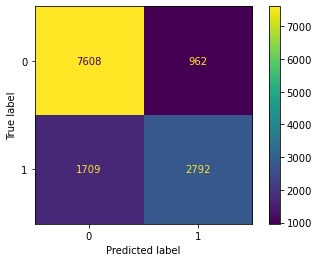

In [45]:
# Confusion Matrix on test data
model.eval() 
all_true_labels = []
all_pred_labels = []

with torch.no_grad(): 
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']
        doc_idx = batch['doc_idx'].to(device)

        outputs = model(input_ids, doc_idx, attention_mask)

        for annotator, logits in outputs.items():
            annotator_labels = labels[annotator].long().to(device)
            mask = annotator_labels != -1 
            if mask.sum() > 0: 
                masked_logits = logits[mask]
                masked_labels = annotator_labels[mask]
                
                predicted_labels = torch.argmax(masked_logits, dim=1)
                
                all_true_labels.extend(masked_labels.cpu().numpy())
                all_pred_labels.extend(predicted_labels.cpu().numpy())

cm = confusion_matrix(all_true_labels, all_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [54]:
# binary
train_losses = [6.327, 5.682, 5.286, 5.034, 4.817, 4.676, 4.528]
train_accuracies = [0.635, 0.726, 0.770, 0.802, 0.824, 0.839, 0.855]

# multi-class
train_losses = [11.489, 11.437, 11.306, 11.156, 11.127, 11.183, 11.159,  11.162]
train_accuracies = [0.276, 0.331, 0.378, 0.412, 0.427, 0.423, 0.417, 0.427]

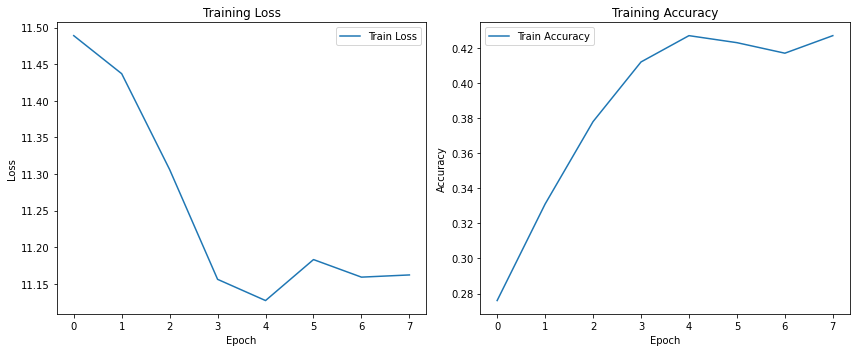

In [55]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_plots.png', dpi=300)  
plt.show()

*Other code experimented with but not used in final implementation.*

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss